# Figure 2: Switching curve of mean-field equilibrium and mean-field global optimum
## Trajectory of the dynamics of both policies 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.pyplot as plt
from mfg_computation import Parameters, mf_equilibrium, mf_optimum, compute_switching_curve
%matplotlib inline
import ternary


In [4]:
PARAMS = Parameters() # default parameters from paper
gamma = PARAMS.gamma # infection rate
rho = PARAMS.rho     # recovery rate
vac_min, theta = PARAMS.vac_min, PARAMS.theta # min/max vaccination rate
T = PARAMS.T # time horizon

c_V = PARAMS.c_V       # cost per unit time of vaccination
c_I = PARAMS.c_I      # cost per unit time of infection

# initial conditions
S0 = 0.4        # proportion of susceptible at t=0
I0 = 0.4        # proportion of infected at t=0

In [5]:
mfe_pol = np.load('data/equi_mf.npy')
mfopt_pol = np.load('data/globalopt_mf.npy')
                
sw_mfopt_x, sw_mfopt_y = compute_switching_curve(PARAMS, mfopt_pol)     
sw_mfe_x, sw_mfe_y = compute_switching_curve(PARAMS, mfe_pol)     

In [6]:
C = 10000
def compute_traj(thr):
    x_S = np.zeros(C+1)
    x_I = np.zeros(C+1)
    policy = np.zeros(C+1)
    x_S[0] = S0; x_I[0] = I0
    for t in range(C):
        if t < thr*C:
            policy[t] = theta
        else:
            policy[t] = vac_min
        x_S[t+1] = x_S[t]+(-gamma*x_I[t]*x_S[t] - policy[t]*x_S[t])*1./C
        x_I[t+1] = x_I[t]+(gamma*x_S[t] - rho)*x_I[t]*1./C
    return x_S, x_I

def compute_traj_mfe(PARAMS, S0, I0, C):
    cost_mfe, t_mfe = mf_equilibrium(PARAMS, S0, I0, C)
    x_S, x_I = compute_traj(t_mfe)
    return x_S, x_I
    
def compute_traj_mfopt(PARAMS, S0, I0, C):
    cost_mfopt, t_mfopt = mf_optimum(PARAMS, S0, I0, C)
    x_S, x_I = compute_traj(t_mfopt)
    return x_S, x_I

traj_S_mfe, traj_I_mfe  = compute_traj_mfe(PARAMS, S0, I0, C)
traj_S_mfopt, traj_I_mfopt  = compute_traj_mfopt(PARAMS, S0, I0, C)

In [7]:

sw_curve_mfopt = []
for i in range(len(sw_mfopt_x)):
    v_aux = [sw_mfopt_x[i], sw_mfopt_y[i], 1-sw_mfopt_x[i]-sw_mfopt_y[i]]
    sw_curve_mfopt.append(v_aux)
sw_curve_mfe = []
for i in range(len(sw_mfe_x)):
    v_aux = [sw_mfe_x[i], sw_mfe_y[i], 1-sw_mfe_x[i]-sw_mfe_y[i]]
    sw_curve_mfe.append(v_aux)
traj_mfe = []    
for i in range(len(traj_S_mfe)):
    v_aux2 = [traj_S_mfe[i], traj_I_mfe[i]]
    traj_mfe.append(v_aux2)
traj_mfopt = []    
for i in range(len(traj_S_mfopt)):
    v_aux2 = [traj_S_mfopt[i], traj_I_mfopt[i]]
    traj_mfopt.append(v_aux2)


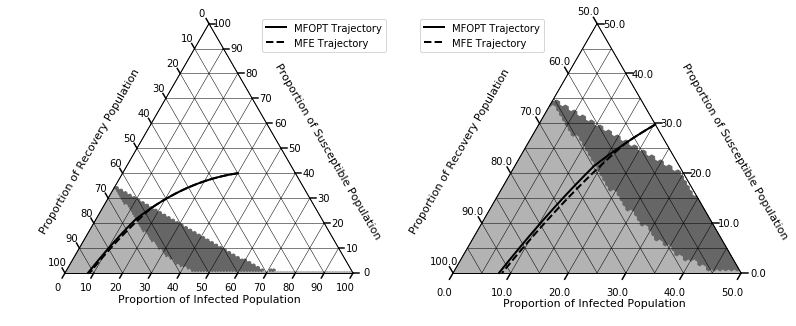

In [9]:
scale = 100

fig = ternary.plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

tax1 = ternary.TernaryAxesSubplot(ax=ax1, scale=100)
tax1.boundary(linewidth=1.0)
tax1.gridlines(color="black", multiple=10, linewidth=0.5, ls='-')
tax1.ax.axis("equal")
tax1.ax.axis("off")

tax2 = ternary.TernaryAxesSubplot(ax=ax2,scale=50)
axes_colors = {'b': 'r', 'r': 'r', 'l': 'r'}
tax2.boundary(linewidth=1.0)
tax2.gridlines(color="k", multiple=5, linewidth=0.5, ls='-')
tax2.ax.axis("equal")
tax2.ax.axis("off")


def f(x):
    swMFOPT = np.interp(x[0], sw_mfopt_x, sw_mfopt_y)
    swMFEQ = np.interp(x[0], sw_mfe_x, sw_mfe_y)
    if x[1] <= swMFOPT:
        return (.7,.7,.7,1)
    elif x[1] <= swMFEQ:
        return (.4,.4,.4,1)
    else:
        return (0,0,0,0)
    
def f2(x):
    swMFOPT = np.interp(x[0], sw_mfopt_x, sw_mfopt_y)
    swMFEQ = np.interp(x[0], sw_mfe_x, sw_mfe_y)
    if 1-x[0]-x[1]<0.5:
        return (0,0,0,0)
    elif x[1] <= swMFOPT:
        return (.7,.7,.7,1)
    elif x[1] <= swMFEQ:
        return (.4,.4,.4,1)
    else:
        return (0,0,0,0)
    
def generate_heatmap_data():
    from ternary.helpers import simplex_iterator
    d1 = dict()
    d2 = dict()
    for (i, j, k) in simplex_iterator(scale):
        d1[(i, j, k)] = f([i/scale, j/scale])
        d2[(i, j, k)] = f2([i/scale, j/scale])
    return d1, d2
data, data_zoom = generate_heatmap_data()


tax1.heatmap(data, style="hexgonal", use_rgba=True)
tax2.heatmap(data_zoom, style="hexgonal", use_rgba=True)

fig.delaxes(fig.axes[3])
fig.delaxes(fig.axes[2])


fontsize = 11
#tax1.set_title("Switching Curve")
tax1.left_axis_label("Proportion of Recovery Population", fontsize=fontsize, offset=0.12)
tax1.right_axis_label("Proportion of Susceptible Population", fontsize=fontsize, offset=0.12)
tax1.bottom_axis_label("Proportion of Infected Population", fontsize=fontsize, offset=0.)
#tax2.set_title("Zoomed region")
tax2.left_axis_label("Proportion of Recovery Population", fontsize=fontsize, offset=0.17)
tax2.right_axis_label("Proportion of Susceptible Population", fontsize=fontsize, offset=0.17)
tax2.bottom_axis_label("Proportion of Infected Population", fontsize=fontsize, offset=0.03)

tax1.ticks(multiple=10,offset=0.02)
tax2.set_axis_limits({'b': [0, 50], 'l': [50, 100], 'r': [0, 50]})
tax2.get_ticks_from_axis_limits(multiple=10)
tick_formats = "%.1f"
tax2.set_custom_ticks(fontsize=10, offset=0.025, multiple=10, tick_formats=tick_formats)

tax1.plot(np.array(traj_mfopt)*scale, linewidth=2.0, color='k', label="MFOPT Trajectory")
tax1.plot(np.array(traj_mfe)*scale, linewidth=2.0, color='k', linestyle='dashed', label="MFE Trajectory")

traj_mfopt_zoom = []
traj_mfe_zoom = []
for i in range(len(traj_mfopt)):
    v = traj_mfopt[i]
    if 1-v[0]-v[1]>0.5:
          traj_mfopt_zoom.append(v)
    v = traj_mfe[i]
    if 1-v[0]-v[1]>0.5:
          traj_mfe_zoom.append(v)
tax2.plot(np.array(traj_mfopt_zoom)*scale, linewidth=2.0, color='k', label="MFOPT Trajectory")
tax2.plot(np.array(traj_mfe_zoom)*scale, linewidth=2.0, color='k', linestyle='dashed', label="MFE Trajectory")

fig.set_facecolor("w")

tax1.ax.set_position([0.01, 0.05, 0.46, 0.8])
tax2.ax.set_position([0.50, 0.05, 0.46, 0.8])

tax1.resize_drawing_canvas()
tax2.resize_drawing_canvas()
tax1.legend()
tax2.legend()
tax1.get_axes().axis('off')
tax2.get_axes().axis('off')

ternary.plt.show()